In [5]:
!pip install pandas seaborn pyshark scikit-learn tensorflow nest_asyncio asyncio scapy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scapy: filename=scapy-2.5.0-py2.py3-none-any.whl size=1444327 sha256=d534cc953afd71d420add239770c408036fdc306fa2eab1a85beec5ad9444abf
  Stored in directory: /root/.cache/pip/wheels/82/b7/03/8344d8cf6695624746311bc0d389e9d05535ca83c35f90241d
Successfully built scapy


Epoch 1/300
30/30 [==============================] - 2s 12ms/step - loss: 0.2130 - val_loss: 0.1110
Epoch 2/300
30/30 [==============================] - 0s 4ms/step - loss: 0.0481 - val_loss: 0.0046
Epoch 3/300
30/30 [==============================] - 0s 5ms/step - loss: 0.0050 - val_loss: 0.0032
Epoch 4/300
30/30 [==============================] - 0s 5ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 5/300
30/30 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0029
Epoch 6/300
30/30 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 7/300
30/30 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 8/300
30/30 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 9/300
30/30 [==============================] - 0s 5ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 10/300
30/30 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 11

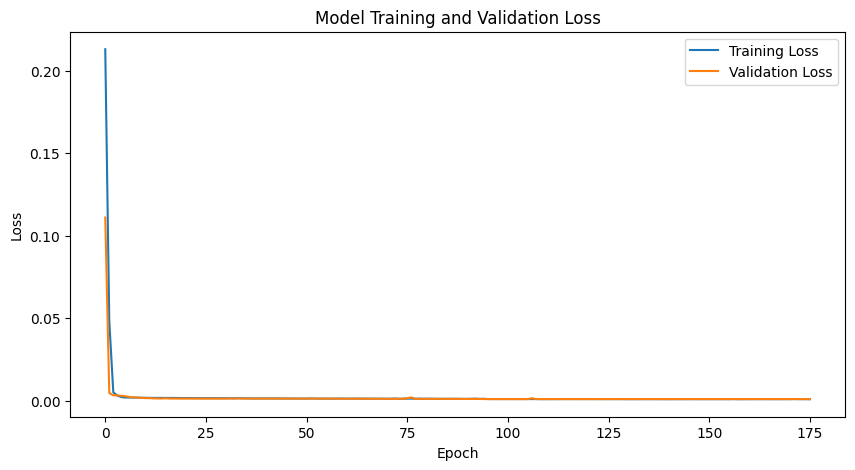

30/30 [==============================] - 0s 2ms/step


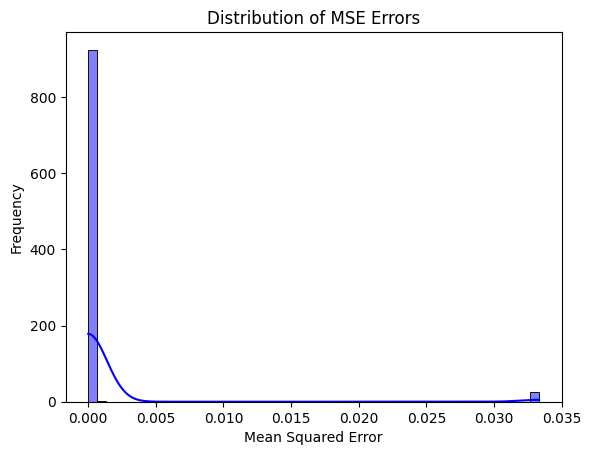

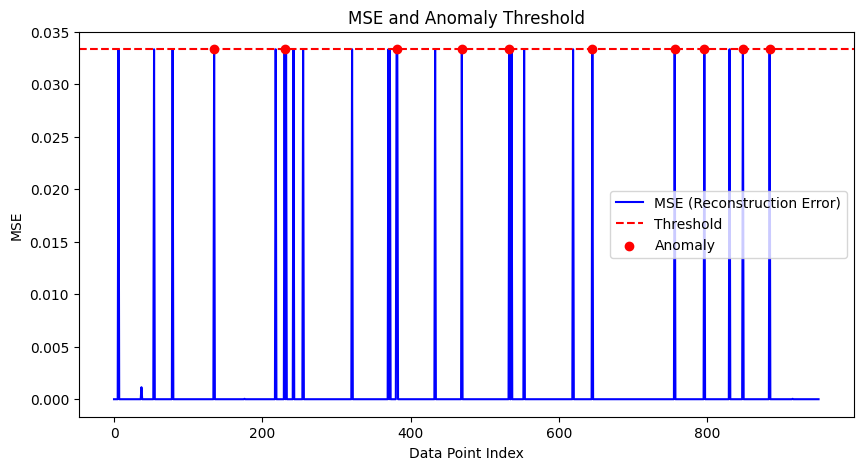

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scapy.all import rdpcap, IP
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def loadData(file_path, packet_limit=1000):
    packets = rdpcap(file_path, count=packet_limit)
    dataList = []
    for packet in packets:
        if IP in packet:
            dataList.append({
                "packetLength": len(packet),
                "transportLayer": packet[IP].proto,
                "highestLayer": packet.lastlayer().name,
                "srcIP": packet[IP].src,
                "dstIP": packet[IP].dst
            })
    return pd.DataFrame(dataList)

def preprocessData(dataFrame):
    dataFrame['isTCP'] = (dataFrame['transportLayer'] == 6).astype(int)
    dataFrame['isUDP'] = (dataFrame['transportLayer'] == 17).astype(int)
    dataFrame.drop(columns=['transportLayer'], inplace=True)
    features = pd.get_dummies(dataFrame, columns=['highestLayer', 'srcIP', 'dstIP'])
    scaler = MinMaxScaler()
    features[features.columns] = scaler.fit_transform(features)
    return features

def buildAutoencoderModel(inputDimension):
    inputLayer = Input(shape=(inputDimension,))
    encoder = Dense(64, activation='relu')(inputLayer)
    encoder = BatchNormalization()(encoder)
    encoder = Dense(32, activation='relu')(encoder)
    encoder = Dropout(0.2)(encoder)
    encoder = Dense(16, activation='relu')(encoder)
    decoder = Dense(32, activation='relu')(encoder)
    decoder = Dense(64, activation='relu')(decoder)
    outputLayer = Dense(inputDimension, activation='sigmoid')(decoder)
    autoencoder = Model(inputs=inputLayer, outputs=outputLayer)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return autoencoder

def showTrainingProgress(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def evaluateModel(autoencoder, testData):
    predictions = autoencoder.predict(testData)
    mseErrors = np.mean(np.power(testData - predictions, 2), axis=1)
    sns.histplot(mseErrors, bins=50, kde=True, color='blue')
    plt.title('Distribution of MSE Errors')
    plt.xlabel('Mean Squared Error')
    plt.ylabel('Frequency')
    plt.show()
    return mseErrors, predictions

def findThreshold(mseErrors):
    return np.percentile(mseErrors, 99)

def plotErrors(mseErrors, threshold):
    plt.figure(figsize=(10, 5))
    indices = np.arange(len(mseErrors))
    plt.plot(indices, mseErrors, label='MSE (Reconstruction Error)', color='blue')
    plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')

    anomalies = mseErrors > threshold
    plt.scatter(indices[anomalies], mseErrors[anomalies], color='red', label='Anomaly', zorder=5)

    plt.title('MSE and Anomaly Threshold')
    plt.xlabel('Data Point Index')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    networkData = loadData('/content/maccdc2010_00000_20100310205651.pcap', packet_limit=5000)
    processedData = preprocessData(networkData)
    trainData, testData = train_test_split(processedData, test_size=0.2, random_state=42)
    autoencoder = buildAutoencoderModel(trainData.shape[1])
    earlyStop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
    trainingHistory = autoencoder.fit(trainData, trainData, epochs=300, batch_size=128, validation_data=(testData, testData), callbacks=[earlyStop])
    showTrainingProgress(trainingHistory)
    mseErrors, predictions = evaluateModel(autoencoder, testData)
    detectionThreshold = findThreshold(mseErrors)
    plotErrors(mseErrors, detectionThreshold)
